First 5 rows of the dataset:
         Date        Open        High         Low       Close   Adj Close  \
0  2016-11-02  778.200012  781.650024  763.450012  768.700012  768.700012   
1  2016-11-03  767.250000  769.950012  759.030029  762.130005  762.130005   
2  2016-11-04  750.659973  770.359985  750.560974  762.020020  762.020020   
3  2016-11-07  774.500000  785.190002  772.549988  782.520020  782.520020   
4  2016-11-08  783.400024  795.632996  780.190002  790.510010  790.510010   

    Volume  
0  1872400  
1  1943200  
2  2134800  
3  1585100  
4  1350800  
------------------------------
Running trading simulation with step-by-step output...
------------------------------
Day 30, Date: 2016-12-15, Price: 797.85
Action: Buy 1 unit at 797.85
Current Balance: 9202.15, Inventory: 1 unit(s)
------------------------------
Day 31, Date: 2016-12-16, Price: 790.80
Action: Hold
Current Balance: 9202.15, Inventory: 1 unit(s)
------------------------------
Day 32, Date: 2016-12-19, Price: 79

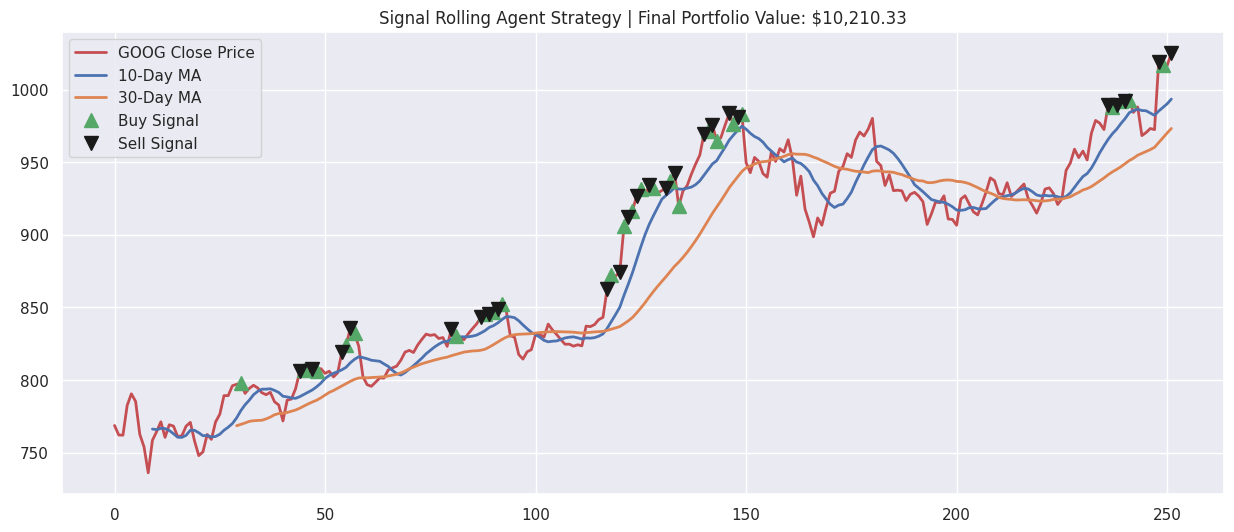

In [7]:
# ### 1. Importing Libraries and Initial Setup
import sys
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time

# Suppress warnings for a cleaner output
if not sys.warnoptions:
    warnings.simplefilter('ignore')

# Set the visual style for plots
sns.set()

# ### 2. Loading the Dataset
# Load the stock data from the CSV file
df = pd.read_csv('GOOG-year.csv')
print("First 5 rows of the dataset:")
print(df.head())
print("-" * 30)

# ### 3. Defining Trading Indicators
# Function to calculate the moving average
def moving_average(x):
    return np.mean(x)

# Function to calculate Bollinger Bands
def bollinger_bands(x, std):
    ma = moving_average(x)
    sd = np.std(x)
    return ma + (std * sd), ma - (std * sd)

# ### 4. Building the Trading Agent
# Defines the trading agent and its logic
class Agent:
    def __init__(self, money):
        self.money = money
        self.inventory = []
        self.states_sell = []
        self.states_buy = []
        self.states_hold = []

    # Defines the agent's action based on market signals
    def act(self, price, index, short_ma, long_ma, ub, lb):
        # Buy Signals
        # 1. Mean Reversion: Price is below the lower Bollinger Band
        # 2. Trend Following: Short-term MA crosses above long-term MA
        if (price < lb or short_ma > long_ma) and len(self.inventory) == 0 and self.money >= price:
            self.inventory.append(price)
            self.money -= price
            self.states_buy.append(index)
            return f"Action: Buy 1 unit at {price:.2f}"

        # Sell Signals
        # 1. Mean Reversion: Price is above the upper Bollinger Band
        # 2. Trend Following: Short-term MA crosses below long-term MA
        # Additional condition: Only sell if it's profitable
        elif (price > ub or short_ma < long_ma) and len(self.inventory) > 0:
            bought_price = self.inventory[0]
            if price > bought_price: # Only sell for a profit
                profit = price - bought_price
                self.inventory.pop(0)
                self.money += price
                self.states_sell.append(index)
                return f"Action: Sell 1 unit at {price:.2f} for a profit of {profit:.2f}"
            else:
                self.states_hold.append(index)
                return "Action: Hold (Sell signal ignored - not profitable)"

        # Hold signal
        else:
            self.states_hold.append(index)
            return "Action: Hold"

# ### 5. Setting Simulation Parameters
initial_money = 10000
long_window_size = 30
short_window_size = 10
std_dev = 1.5  # Tighter bands for more frequent trades

# Initialize the agent
agent = Agent(initial_money)

# ### 6. Running the Trading Simulation
print("Running trading simulation with step-by-step output...")
print("-" * 30)

# Loop through the dataset to simulate the trading strategy
for i in range(long_window_size, len(df['Close'])):

    # Use rolling windows of data for calculations
    long_current_window = df['Close'][i - long_window_size: i]
    short_current_window = df['Close'][i - short_window_size: i]

    # Calculate indicators for the current time window
    long_ma = moving_average(long_current_window)
    short_ma = moving_average(short_current_window)
    ub, lb = bollinger_bands(long_current_window, std_dev)

    # Get the agent's action and print the status for the current step
    action_taken = agent.act(df['Close'][i], i, short_ma, long_ma, ub, lb)

    # Print the state at the current timestep
    print(f"Day {i}, Date: {df['Date'][i]}, Price: {df['Close'][i]:.2f}")
    print(f"{action_taken}")
    print(f"Current Balance: {agent.money:.2f}, Inventory: {len(agent.inventory)} unit(s)")
    print("-" * 30)

    # Add a brief pause to make the output readable
    time.sleep(0.1)

print("Simulation complete.")
print("-" * 50)


# ### 7. Calculating Final Performance
# Calculate the final portfolio value
final_portfolio_value = agent.money
if len(agent.inventory) > 0:
    # Sell any remaining inventory at the last closing price
    last_price = df['Close'].iloc[-1]
    final_portfolio_value += len(agent.inventory) * last_price
    print(f"Sold remaining {len(agent.inventory)} unit(s) at the last price of {last_price:.2f}")

# Calculate the total return
total_return = final_portfolio_value - initial_money
return_percentage = (total_return / initial_money) * 100

print(f"Initial Investment: ${initial_money:,.2f}")
print(f"Final Portfolio Value: ${final_portfolio_value:,.2f}")
print(f"Total Return: ${total_return:,.2f} ({return_percentage:.2f}%)")
print("-" * 50)


# ### 8. Visualizing the Results
# Create the plot to visualize the trading signals
print("Generating plot...")
fig = plt.figure(figsize = (15, 6))
plt.plot(df['Close'], color='r', lw=2., label='GOOG Close Price')
plt.plot(df['Close'].rolling(window=short_window_size).mean(), lw=2., label='10-Day MA')
plt.plot(df['Close'].rolling(window=long_window_size).mean(), lw=2., label='30-Day MA')


# Add markers to indicate buy and sell signals on the chart
plt.plot(df.index,
         df['Close'],
         '^',
         markersize=10,
         color='g',
         label = 'Buy Signal',
         markevery = agent.states_buy)

plt.plot(df.index,
         df['Close'],
         'v',
         markersize=10,
         color='k',
         label = 'Sell Signal',
         markevery = agent.states_sell)


# Set the title and legend for the plot
plt.title(f'Signal Rolling Agent Strategy | Final Portfolio Value: ${final_portfolio_value:,.2f}')
plt.legend(loc='upper left')
plt.show()

